In [1]:
import env
import acquire
import prepare_bootcamp_readme
import requests as req
import pandas as pd
import numpy as np
import utilities as utils
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [2]:
bootcamp_readme_df = pd.read_csv(env.data_path + "coding_bootcamp_readme.csv")

In [3]:
bootcamp_readme_df = prepare_bootcamp_readme.prepare_bootcamp_readme_df(bootcamp_readme_df)

NaN values
     rows  columns
0       4        1
1      15        1
2      17        2
3      19        1
4      23        1
..    ...      ...
269   983        1
270   987        1
271   989        1
272   990        1
273   993        1

[274 rows x 2 columns]
--------------------------------
Empty values
   rows  columns
0   514        2
1   565        2
2   635        2
--------------------------------


In [4]:
bootcamp_readme_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451 entries, 0 to 997
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             451 non-null    object
 1   language         451 non-null    object
 2   readme_contents  451 non-null    object
dtypes: object(3)
memory usage: 14.1+ KB


## Explore

In [5]:
bootcamp_readme_df.language.value_counts()

JavaScript          184
Jupyter Notebook    157
Python               73
Java                 37
Name: language, dtype: int64

Web development languages seem to dominate repositores (Javascript, Java) with data science languages coming in second (Jupyter notebook and Python).

In [6]:
languages_df = pd.concat([bootcamp_readme_df.language.value_counts(), bootcamp_readme_df.language.value_counts(normalize=True)], axis=1)
languages_df.columns = ['count', 'percent']

In [7]:
print(f"Combined % of web dev languages:  {round(languages_df.loc[['JavaScript', 'Java']].percent.sum(), 4)}")
print(f"Combined % of data science languages:  {round(languages_df.loc[['Jupyter Notebook', 'Python']].percent.sum(), 4)}")

Combined % of web dev languages:  0.49
Combined % of data science languages:  0.51


In [8]:
# The dictionary entry for a language will hold the list of unique words in all the readme files
readme_words_by_language_dict = {}

for language in languages_df.index:
    all_readme_for_language = " ".join(bootcamp_readme_df[bootcamp_readme_df.language == language].readme_contents)
    
    readme_words_by_language_dict[language] = re.sub(r"[^\w\s]", "", all_readme_for_language).split()    

In [9]:
# Count the occurences of the words for each language
word_count_by_lanugage_dict = {}

for language in readme_words_by_language_dict.keys():
    word_count_by_lanugage_dict[language] = pd.Series(readme_words_by_language_dict[language]).value_counts()

In [10]:
# Make an entry in each dictionary for 'all_languages'
all_readme_text = " ".join(bootcamp_readme_df.readme_contents)

readme_words_by_language_dict['all_languages'] = re.sub(r"[^\w\s]", "", all_readme_text).split()

word_count_by_lanugage_dict['all_languages'] = pd.Series(readme_words_by_language_dict['all_languages']).value_counts()

In [11]:
word_counts_df = pd.concat(word_count_by_lanugage_dict.values(), axis=1, sort=False)\
.set_axis(word_count_by_lanugage_dict.keys(), axis=1, inplace=False)\
.fillna(0).apply(lambda s : s.astype(int))

In [12]:
word_counts_df.sort_values(by='all_languages', ascending=False).head(10)

,JavaScript,Jupyter Notebook,Python,Java,all_languages
9,144,248,437,54,883
python,9,589,282,0,880
bootcamp,207,287,141,32,667
data,88,400,120,20,628
code,249,131,108,20,508
use,246,121,96,18,481
project,220,77,88,34,419
using,138,141,71,29,379
run,230,54,66,14,364
file,141,77,123,16,357


The top 10 words in README files for all languages are:  
1. 9
1. de
1. python
1. data
1. bootcamp
1. 1
1. code
1. e
1. 2
1. use

* Are there any words that identify web dev languages from data science languages?

In [13]:
not_js_in_python = word_counts_df[word_counts_df.JavaScript == 0].sort_values(by='Python').tail(10)
not_js_in_jupyter = word_counts_df[word_counts_df.JavaScript == 0].sort_values(by='Jupyter Notebook').tail(10)

In [14]:
not_java_in_python = word_counts_df[word_counts_df.Java == 0].sort_values(by='Python').tail(10)
not_java_in_jupyter = word_counts_df[word_counts_df.Java == 0].sort_values(by='Jupyter Notebook').tail(10)

In [15]:
data_sci_words_df = pd.concat([not_java_in_jupyter, not_java_in_python, not_js_in_jupyter,\
                               not_js_in_python])

In [16]:
# Words usually found in data science README files, but not in web dev
data_sci_words_df.index.unique()

Index(['panda', 'neural', 'x', 'w', 'analysis', 'university', 'science',
       'jupyter', 'notebook', 'python', 'variable', 'heroku', 'veri', 'track',
       'module', 'print', 'django', 'reward', 'function', 'cell',
       'computational', 'tensorflow', 'visualization', 'jezyku', 'anaconda',
       'def', 'steering', 'pycharm', 'selenium', 'deepracer', 'race', 'agent',
       'car', 'milvus', 'olarak'],
      dtype='object')

In [17]:
not_python_in_js = word_counts_df[word_counts_df.Python == 0].sort_values(by='JavaScript').tail(10)
not_jupyter_in_js = word_counts_df[word_counts_df['Jupyter Notebook'] == 0].sort_values(by='JavaScript').tail(10)

In [18]:
not_python_in_java = word_counts_df[word_counts_df.Python == 0].sort_values(by='Java').tail(10)
not_jupyter_in_java = word_counts_df[word_counts_df['Jupyter Notebook'] == 0].sort_values(by='Java').tail(10)

In [19]:
web_dev_words_df = pd.concat([not_jupyter_in_java, not_jupyter_in_js, not_python_in_java, not_python_in_js])

In [20]:
web_dev_words_df.index.unique()

Index(['xml', 'robolectric', 'odev', 'cordapp', 'genymotion', 'treasure',
       'layout', 'expense', 'checkpoint', 'android', 'width100px', 'altbr',
       'h3', 'var', 'hr', 'td', 'yarn', 'nodejs', 'id', 'npm', 'criacao',
       'intent', 'com', 'spring', 'aula', 'uma', 'desafio', 'na', 'em',
       'projeto', 'um', 'react'],
      dtype='object')

In [21]:
word_counts_df['web_dev_languages'] = word_counts_df.Java + word_counts_df.JavaScript

In [22]:
word_counts_df['data_sci_languages'] = word_counts_df['Jupyter Notebook'] + word_counts_df['Python']

In [23]:
word_counts_df['other_languages'] = word_counts_df.all_languages - word_counts_df.data_sci_languages - word_counts_df.web_dev_languages

In [24]:
word_counts_df

,JavaScript,Jupyter Notebook,Python,Java,all_languages,web_dev_languages,data_sci_languages,other_languages
javascript,267,1,3,1,272,268,4,0
code,249,131,108,20,508,269,239,0
use,246,121,96,18,481,264,217,0
para,233,65,5,18,321,251,70,0
run,230,54,66,14,364,244,120,0
...,...,...,...,...,...,...,...,...
hardnetworkingdemo,0,0,0,1,1,1,0,0
asynctaskhttpdeveloperandroidcomreferenceandroidosasynctaskhtml,0,0,0,1,1,1,0,0
mvnw,0,0,0,1,1,1,0,0
asynctasks,0,0,0,1,1,1,0,0


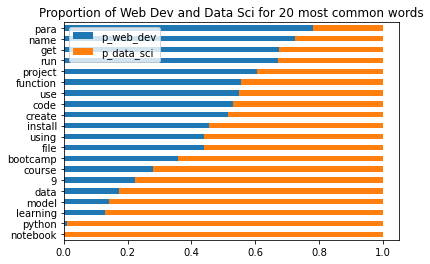

In [25]:
(word_counts_df.assign(p_web_dev=word_counts_df.web_dev_languages / word_counts_df.all_languages, \
                      p_data_sci=word_counts_df.data_sci_languages / word_counts_df.all_languages)\
.sort_values(by='all_languages')\
[['p_web_dev', 'p_data_sci']]\
.tail(20).sort_values('p_web_dev').plot.barh(stacked=True))

plt.title('Proportion of Web Dev and Data Sci for 20 most common words')
plt.legend(loc="best")
plt.show()

* 'Python', 'learning', and 'data'  overwhelmingly in data science repositories
* 'e', 'de', and 'para' are present web dev repositories
    * Are these fragments of HTML elements or CSS selectors?

(-0.5, 799.5, 999.5, -0.5)

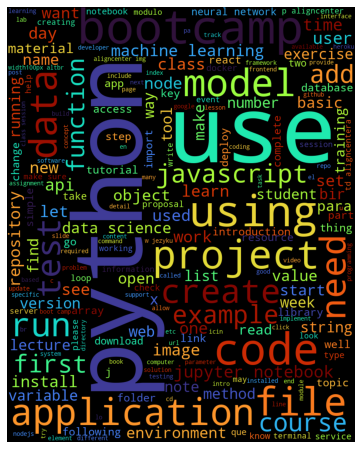

In [26]:
img = WordCloud(background_color="black", height=1000, width=800, colormap="turbo")\
    .generate(" ".join(readme_words_by_language_dict['all_languages']))

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")

In [27]:
web_dev_word_list = \
list(set(readme_words_by_language_dict['Java'] + readme_words_by_language_dict['JavaScript']))

In [28]:
data_sci_word_list = list(set(readme_words_by_language_dict['Jupyter Notebook'] + readme_words_by_language_dict['Python']))

(-0.5, 799.5, 999.5, -0.5)

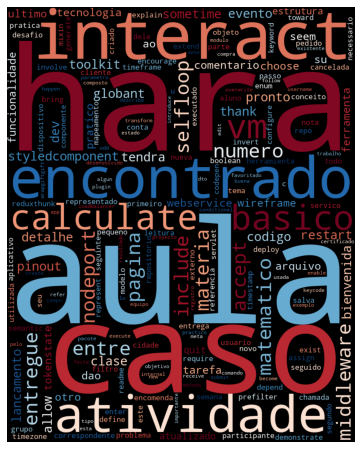

In [29]:
img = WordCloud(background_color="black", height=1000, width=800, colormap="RdBu")\
    .generate(" ".join(web_dev_word_list))

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")

(-0.5, 799.5, 999.5, -0.5)

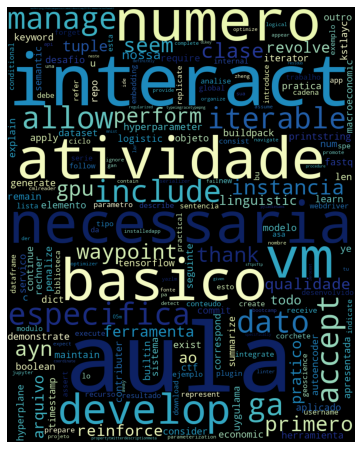

In [30]:
img = WordCloud(background_color="black", height=1000, width=800, colormap="YlGnBu")\
    .generate(" ".join(data_sci_word_list))

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")

In [31]:
# Bigrams
top_20_webdev_bigrams = pd.Series(nltk.ngrams(web_dev_word_list, 2)).value_counts().head(20)
top_20_webdev_bigrams.head()

(sinenvolturas, orneklerexamples)                                                                                                                                       1
(nombresemanapractico, nodeport32348)                                                                                                                                   1
(behaviourhttpsgithubcommacosgroveandroidbootcampprojectcommitff41e46f18da9ab904607f62a766368459b78db2, hrefhttpsgithubcomyadsnodemailerexpresshandlebarsnodemailer)    1
(continuous, conceptsgonodechallenge1)                                                                                                                                  1
(ab, naturally)                                                                                                                                                         1
dtype: int64

In [32]:
# Bigrams
top_20_datasci_bigrams = pd.Series(nltk.ngrams(data_sci_word_list, 2)).value_counts().head(20)
top_20_datasci_bigrams.head()

(metodlardic49fermetodlar, boyunca)                                           1
(prototype, celeste)                                                          1
(ariel, 116b8645454545451b9a40)                                               1
(bilgiye, mathhttpsgithubcomopensourceeconbootcamp2019treemastermathweek3)    1
(pclementstudent42fr, elevator)                                               1
dtype: int64

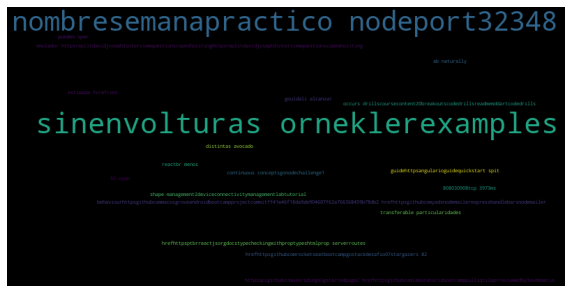

In [33]:
# Generate wordcloud following example from curriculum
data = {k[0] + ' ' + k[1]: v for k, v in top_20_webdev_bigrams.to_dict().items()}
img = WordCloud(background_color='black', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

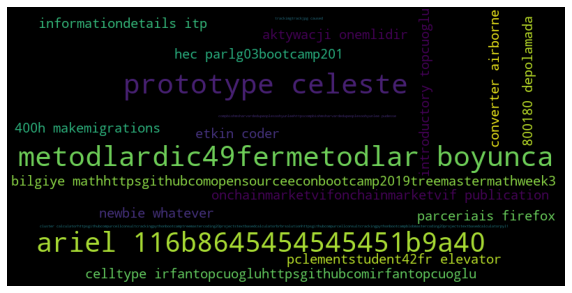

In [34]:
# Generate wordcloud following example from curriculum
data = {k[0] + ' ' + k[1]: v for k, v in top_20_datasci_bigrams.to_dict().items()}
img = WordCloud(background_color='black', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [35]:
word_list = pd.Series(readme_words_by_language_dict['all_languages'])

# Make dataframe with raw count and frequencies
word_freq_df = (pd.DataFrame({'raw_count': word_list.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

word_freq_df.sort_values(by='frequency', ascending=False).head(20)

,raw_count,frequency,augmented_frequency
9,883,0.008342,1.000000
python,880,0.008314,0.996602
bootcamp,667,0.006302,0.755379
data,628,0.005933,0.711212
code,508,0.004800,0.575311
use,481,0.004544,0.544734
project,419,0.003959,0.474519
using,379,0.003581,0.429219
run,364,0.003439,0.412231
file,357,0.003373,0.404304


In [36]:
# Calculate IDF
def idf(word, document_series):
    n_occurences = sum([1 for doc in document_series if word in doc])
    
    return np.log(len(document_series) / n_occurences)

In [37]:
word_freq_df = word_freq_df.reset_index()
word_freq_df = word_freq_df.rename(columns={'index' : 'word'})

In [38]:
word_freq_df['idf'] = word_freq_df.word.apply(idf, document_series=bootcamp_readme_df.readme_contents)

word_freq_df.sort_values(by='idf', ascending=False).head(20)

,word,raw_count,frequency,augmented_frequency,idf
10280,optimal,1,0.000009,0.001133,6.111467
13261,httpsgithubcommolochventureswhitepaperblobmast...,1,0.000009,0.001133,6.111467
13259,1297,1,0.000009,0.001133,6.111467
13258,dusunun,1,0.000009,0.001133,6.111467
13256,analyticshttpswwwcontinuumio,1,0.000009,0.001133,6.111467
13255,analysing,1,0.000009,0.001133,6.111467
13254,performs,1,0.000009,0.001133,6.111467
13253,microsofthttpsstudentpartnersmicrosoftcom,1,0.000009,0.001133,6.111467
13252,srcpicdemo1png,1,0.000009,0.001133,6.111467
13251,windowssetupmd,1,0.000009,0.001133,6.111467


In [39]:
word_freq_df['tf_idf'] = word_freq_df.frequency * word_freq_df.idf

word_freq_df.sort_values(by='tf_idf', ascending=False).head(20)

,word,raw_count,frequency,augmented_frequency,idf,tf_idf
1,python,880,0.008314,0.996602,1.114255,0.009264
0,9,883,0.008342,1.000000,0.958176,0.007994
14,model,301,0.002844,0.340883,1.937080,0.005509
3,data,628,0.005933,0.711212,0.924082,0.005483
16,notebook,286,0.002702,0.323896,1.834801,0.004958
23,javascript,272,0.002570,0.308041,1.921813,0.004939
15,function,288,0.002721,0.326161,1.807402,0.004918
7,using,379,0.003581,0.429219,1.323976,0.004741
6,project,419,0.003959,0.474519,1.162707,0.004603
4,code,508,0.004800,0.575311,0.952412,0.004571


In [59]:
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(bootcamp_readme_df.readme_contents)
y = bootcamp_readme_df.language

In [65]:
X = pd.DataFrame(X.todense(), columns=tfidf.get_feature_names())

In [63]:
bootcamp_readme_df['is_webdev'] = bootcamp_readme_df.language.apply(lambda lang : True if (lang == 'Java') | (lang == 'JavaScript') else False)

In [70]:
is_webdev = bootcamp_readme_df.is_webdev

In [72]:
is_webdev = is_webdev.reset_index()

In [73]:
is_webdev = is_webdev.drop(columns=['index'])

In [75]:
X = pd.concat([X, is_webdev], axis=1)

In [77]:
# Only works when X is left as a sparse matrix
# vector_bootcamp_readme_df = pd.DataFrame(X, y)
# vector_bootcamp_readme_df = vector_bootcamp_readme_df.reset_index()
# vector_bootcamp_readme_df = bootcamp_readme_df.rename(columns={'index' : 'label', 0 : 'text'})

In [42]:
# vector_bootcamp_readme_df.language.value_counts()

JavaScript          184
Jupyter Notebook    157
Python               73
Java                 37
Name: language, dtype: int64

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1414)

In [79]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=.3, random_state=1414)

In [80]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

In [81]:
lm = LogisticRegression(class_weight="balanced").fit(X_train, y_train)

In [82]:
train['predicted'] = lm.predict(X_train)
validate['predicted'] = lm.predict(X_validate)
test['predicted'] = lm.predict(X_test)

In [83]:
# Training sample
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 100.00%
---
Confusion Matrix
actual            Java  JavaScript  Jupyter Notebook  Python
predicted                                                   
Java                22           0                 0       0
JavaScript           0          96                 0       0
Jupyter Notebook     0           0                91       0
Python               0           0                 0      43
---
                  precision    recall  f1-score   support

            Java       1.00      1.00      1.00        22
      JavaScript       1.00      1.00      1.00        96
Jupyter Notebook       1.00      1.00      1.00        91
          Python       1.00      1.00      1.00        43

        accuracy                           1.00       252
       macro avg       1.00      1.00      1.00       252
    weighted avg       1.00      1.00      1.00       252



In [84]:
# Training sample
print('Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate.predicted, validate.actual))
print('---')
print(classification_report(validate.actual, validate.predicted))

Accuracy: 80.56%
---
Confusion Matrix
actual            Java  JavaScript  Jupyter Notebook  Python
predicted                                                   
Java                 1           0                 0       0
JavaScript           6          46                 0       0
Jupyter Notebook     0           0                31      11
Python               0           0                 4       9
---
                  precision    recall  f1-score   support

            Java       1.00      0.14      0.25         7
      JavaScript       0.88      1.00      0.94        46
Jupyter Notebook       0.74      0.89      0.81        35
          Python       0.69      0.45      0.55        20

        accuracy                           0.81       108
       macro avg       0.83      0.62      0.63       108
    weighted avg       0.81      0.81      0.78       108



In [85]:
# Test sample
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 84.62%
---
Confusion Matrix
actual            Java  JavaScript  Jupyter Notebook  Python
predicted                                                   
Java                 2           0                 0       0
JavaScript           6          42                 0       0
Jupyter Notebook     0           0                26       3
Python               0           0                 5       7
---
                  precision    recall  f1-score   support

            Java       1.00      0.25      0.40         8
      JavaScript       0.88      1.00      0.93        42
Jupyter Notebook       0.90      0.84      0.87        31
          Python       0.58      0.70      0.64        10

        accuracy                           0.85        91
       macro avg       0.84      0.70      0.71        91
    weighted avg       0.86      0.85      0.83        91



In [105]:
def predict_language_from_readme(trained_model, vectorizer, readme_txt, is_webdev):
    
    readme_txt = utils.nlp_basic_clean(readme_txt)
    readme_txt = re.sub(r"\n", " ", readme_txt)
    readme_txt = utils.nlp_tokenize(readme_txt)
    readme_txt = utils.nlp_remove_stopwords(readme_txt, extra_words=['de', 'e', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'])
    readme_txt = utils.nlp_lemmatize(readme_txt)
    
    readme_txt = pd.Series(readme_txt)
    
    vectorized_readme = vectorizer.transform(readme_txt)
    vectorized_readme = pd.DataFrame(vectorized_readme.todense(), columns=tfidf.get_feature_names())
    vectorized_readme = pd.concat([vectorized_readme, pd.Series(is_webdev)], axis=1)
    
    return trained_model.predict(vectorized_readme)

In [106]:
readme_txt = """
# utilities
## Repository containing utilities for data science program

## How to use this repo

### Choose whether you want a stable release or the most current features:
* Stable
    1. Download the release you wish to use.
    2. Unzip to the project directory where you will be using `utilities.py`
* Current (Recommended)
    1. Clone this repository
    2. If you do not have your own `env.py`:
        1. Remove ".template" from the `env.py.template` file
        2. Set up your `env.py` with the correct settings for your environment
    3. If you have an `env.py`, add the following to your file:
        * `import sys`
        * `sys.path.append("/path/to/utilities")`
            * Replace "/path/to/utilities" with the absolute path to the repository
* Import to your notebook or module using:  `import utilities` or `from utilities import...`
"""

predict_language_from_readme(lm, tfidf, readme_txt, False)

array(['Python'], dtype=object)